# Assignment 3 - Tumor segmentation with uncertainties

### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For radiotherapy treatment, often multiple contrasts are acquired of the same anatomy to have more information for organ delineations. These contrasts have been explored in the previous assignment, and now, your task is to automate the organ delineation! The model to design and train might take any number of image contrasts as an input, and outputs a tumor segmentation. For this task, you will implement and use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate (aim for a Dice score higher than $0.8$ on the validation set).

For machine learning solutions to be reliable in real life scenarios, we may want to improve their explainability. Ideally, models should not only provide their predictions, but provide a motivation for them as well. One form of explainability is through uncertainty metrics, that evaluate how certain layers, and certain nodes affect the output predictions. A popular approach is called *Monte Carlo Dropout*, where during inference, output predictions are generated multiple times using differently initialized dropout layers, therefore the individual predictions will depend on different subsets of the layers' activations. The standard deviation in the generated outputs provides insight into the model's uncertainty about the individual pixels of the predictions, in our case, the segmentations.

Your task is to look through the highly customizable code below, which contains all the main steps for automated image segmentation from using only one contrast as an input. By changing the arrays of the DataGenerator, multiple contrasts can be added as input, similar as in the previous assignmnets. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the report, are:
- How you reached the required performances (a Dice score above $0.8$)
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Once you have reached the required loss on the validation data, only then evaluate your model on the testing data as well.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.
- Using the already implemented Monte Carlo Dropout model, explore the uncertainty of the predictions on the testing data.
- How does your estimated uncertainty depend on the dropout-rates used in the model?
- Look at the uncertainty of each image in the testing dataset. Do you see anything unusual in their values? If so explore the images!

Upload the updated notebook to Canvas by June $2^{nd}$ at 17:00.

Good luck and have fun!

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
random.seed(2023)

import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
!pip install tqdm # Adding tqdm to use progress bars. Unbarable waiting for each epoch to finish without feedback.
from tqdm import tqdm

import tensorflow as tf
tf.random.set_seed(2023)
import tensorflow.keras as keras
# Set keras seed for reproducibility
keras.backend.clear_session()
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from keras.utils import to_categorical

from scipy.ndimage import zoom
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

from mpl_toolkits.axes_grid1 import ImageGrid
from typing import List

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [2]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                im = zoom(im, 0.25)
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    if (np.max(x) > 0):
                        x /= np.max(x)
                    x = zoom(x, 0.25)
                    if (self.arrays[idx] == "mask"):
                        x = x > 0.5
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!
# NOTE: There is now a resizing part of the images, this is to make training easier and faster.

In [3]:
gen_dir = "../data/" # Change if you have copied the data locally on your machine 
array_labels = ['t1', 't1ce', 't2', 'flair', 'mask']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
per_batch = len(array_labels)-1
batch_size = 256


gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like. (STRONGLY encouraged)
# NOTE: What batch size are you using? Should you use more? Or less? What are the pros and cons?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

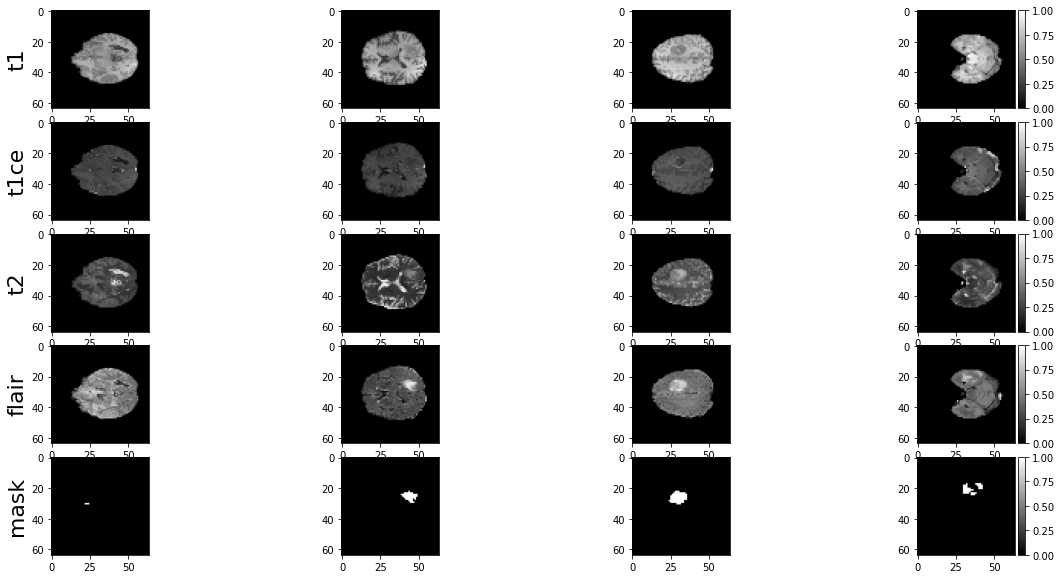

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = len(gen_train.arrays), 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

imgs = gen_train[0]
idx = np.random.randint(0, np.shape(gen_train[0][0])[0], 5)
ii = 0
for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[i][idx[ii], :, :, 0], cmap='gray', vmin=0, vmax=1)

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

### There's a chance, that the bottom row only shows black images, in that case, all four examples are from slices that don't have masks.

A quick summary of the data:

In [5]:
%%skip True
# A quick summary of the data:

print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")
found_masks = 0
for idx, (img) in enumerate(gen_val): # Add the additional inputs inside the brackets
    mask = img[-1]
    found_masks += np.sum(np.sum(mask > 0, (1, 2, 3)) > 0)
print(f"The percentage of slices that contain masks : {np.round(100 * (found_masks / (len(gen_val) * batch_size)), 2)}%")

UsageError: Cell magic `%%skip` not found.


### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

In [6]:
# Import packages important for building and training your model.

import tensorflow.keras
from keras.models import Model
from keras.layers import Dense, Conv2D
from keras.layers import Flatten, Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, concatenate
from keras.layers import BatchNormalization
from keras.layers import Dropout, UpSampling2D
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline

In [7]:
from tensorflow import Tensor
from keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Concatenate, LeakyReLU
from keras.models import Model

def build_generator(in_shape=(64, 64, 1),num_filt=4,dropout_rate=0.2):
    inputs = Input(in_shape)
    # inputs = concatenate([inp1, inp2], axis=3) # If you use multiple inputs, you can concatenate them like this
    x = Conv2D(num_filt, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(num_filt, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 2, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 2, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_2 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_3 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_4 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 16, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 16, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(num_filt * 4, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_4,x], axis=3)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt * 4, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_3,x], axis=3)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt * 2, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_2,x], axis=3)
    x = Conv2D(num_filt * 2, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt * 2, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([inputs, x], axis=3)
    x = Conv2D(num_filt, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filt, 3, activation='relu', padding='same')(x)
    x = Conv2D(1, 1, activation="sigmoid")(x)

    model = Model(inputs=[inputs], outputs=x)
    return model

# NOTE: The generator is a U-Net originally proposed for segmentation tasks.
# NOTE: The model has 4 down- and upsampling layers. Maybe similar to what you have used in Assignment 2. Is it "deep" enough?
# NOTE: Which layers are important for the model? Which layers are important for uncertainty estimation?

## The below cell is all the code you are asked to modify. Change the input contrasts, learning rates and the optimizers to achieve the requirements.

In [8]:
class MonteCarloDropoutModel(object):
    def __init__(self,model):
        self.f = Model(model.inputs, model.layers[-1].output)

    def predict(self,x, n_iter=5):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x], training=True))
        result = tf.math.reduce_std(tf.stack(result, axis=0), axis=0)
        return result

# NOTE: No need to change this model. It's an implementation of a Monte Carlo Dropout Uncertainty estimation model.
# NOTE: This model will predict using your trained model 'n_iter' times, and return the standard deviation of the outputs.
# NOTE: The 'training=True' part ensures that the dropout layers are used in all 'n_iter' predictions.
# NOTE: This means the outputs will be slightly different.

In [9]:
def dice_coef(y_true, y_pred, smooth=0.1):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# NOTE: An implementation of the DICE score, and the corresponding Dice loss, ready for training.
class FocalDiceLoss(keras.losses.Loss):
    def __init__(self, w_focal,w_dice,gamma=2.0, alpha=0.25, smooth=100, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.smooth = smooth
        self.focal_loss = keras.losses.BinaryFocalCrossentropy(gamma=gamma, alpha=alpha)
        self.w_focal = w_focal
        self.w_dice = w_dice
    def call(self, y_true, y_pred):
        # Compute focal loss
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        dice_loss = dice_coef_loss(y_true, y_pred)
        focal_loss = self.focal_loss(y_true, y_pred)
        return self.w_dice*dice_loss + self.w_focal*focal_loss

In [10]:
generator = build_generator(in_shape=(64, 64, per_batch), num_filt=4, dropout_rate=0.2)
generator.summary()
model_name = "unet_4_focal_2"
model_dir = os.path.join("models", model_name)
assert not os.path.exists(model_dir), "Model directory already exists. Please change the model name."
os.makedirs(model_dir)
figure_path = os.path.join(model_dir, "figures")
os.makedirs(figure_path)
checkpoint_path = os.path.join(model_dir, "checkpoints")
os.makedirs(checkpoint_path)
generator_MCunc = MonteCarloDropoutModel(generator)
focal_dice_loss = FocalDiceLoss(w_focal=2,w_dice=0.5)
learning_rate = 0.001
weight_decay = 0.0001
clipnorm = 2.0
optimizer = Adam(learning_rate=learning_rate, clipnorm=clipnorm, decay=weight_decay)
generator.compile(loss=focal_dice_loss, metrics=dice_coef, optimizer=optimizer)
# NOTE: After building the model, you also need to build the uncertainty model. No need to change anything about that part.
# NOTE: Motivate your selection of the optimizer and learning rate.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 4)    148         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 4)    148         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 4)    0           ['conv2d_1[0][0]']               
                                                                                              

## Training Preprocessing Modules

In [11]:
def pre_prosses(data):
    inputs = data[:-1]
    targets = data[-1]
    inputs = np.stack(inputs, axis=-1).squeeze()
    return inputs, targets

In [12]:
# Augmentation class for used in the training pipeline.
from skimage.transform import rotate, AffineTransform, warp
# float wrapper for probability
def prob(p: float) -> bool:
    return np.random.random() < p
class Augmentation:
    verbose: bool = False
    # Parent class for all augmentations
    def __init__(self, p: float):
        self.p = p
    @property
    def name(self) -> str:
        return self.__class__.__name__
    def __call__(self, x: np.ndarray,y: np.ndarray) -> np.ndarray:
        if prob(self.p):
            if self.verbose:
                print(f"Augmenting: Applying {self.name}")
            return self.augment(x,y)
        else:
            return x,y
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        raise NotImplementedError
    

class Flip(Augmentation):
    def __init__(self, p: float = 0.5, axis: int = 0):
        super().__init__(p)
        self.axis = axis # 1 for horizontal, 0 for vertical
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        return np.flip(x, axis=self.axis),np.flip(y, axis=self.axis)

class Rotate(Augmentation):
    def __init__(self, p: float = 0.5, angle: float = np.pi/4):
        super().__init__(p)
        self.angle = angle
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Rotate image and fill with zeros
        # Random angle between -angle and angle
        angle = np.random.uniform(-self.angle, self.angle)
        # Batched rotate
        return np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in x]),np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in y])
class Noise(Augmentation):
    def __init__(self, p: float = 0.5, mean: float = 0.0, std: float = 0.1):
        super().__init__(p)
        self.mean = mean
        self.std = std
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        noise = np.random.normal(self.mean, self.std, x.shape)
        return (x + noise, y)

class Mask(Augmentation):
    def __init__(self, p: float = 0.5, max_n_masks: int = 10, mask_size: float = 0.5):
        super().__init__(p)
        self.max_n_masks = max_n_masks
        self.mask_size = mask_size
    def augment(self, x: np.ndarray, y:np.ndarray) -> np.ndarray:
        # Random number of masks
        n_masks = np.random.randint(1, self.max_n_masks)
        w = x.shape[-3]
        h = x.shape[-2]
        for _ in range(n_masks):
            # Random mask size
            mask_size = np.random.uniform(low=self.mask_size/2, high=self.mask_size)
            # Random mask position
            x1 = np.random.randint(0, w)
            y1 = np.random.randint(0, h)
            x2 = int(x1 + w * mask_size)
            y2 = int(y1 + h * mask_size)
            x[:, x1:x2, y1:y2,:] = 0
        return (x, y)

class Translate(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random translation factor
        tx = np.random.uniform(-self.factor, self.factor) * x.shape[0]
        ty = np.random.uniform(-self.factor, self.factor) * x.shape[1]
        # Affine transform, grayscale image so no need to transform channels
        tform = AffineTransform(translation=(tx, ty))
        # Apply transform, Image will be filled with zeros
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y

class Shear(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random shear factor
        shear_factor = np.random.uniform(-self.factor, self.factor)
        # Create affine transform
        tform = AffineTransform(shear=shear_factor)
        # Use warp to apply transform
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y
class Augmentor:
    """
    Augmentations:
    flip_x: float
        Probability of flipping the image horizontally
    flip_y: float
        Probability of flipping the image vertically
    rotate: float
        Probability of rotating the image
    radians: float
        Maximum rotation angle in radians
    translate: float
        Probability of translating the image
    noise: float
        Probability of adding noise to the image
    noise_std: float
        Standard deviation of the noise
    noise_mean: float
        Mean of the noise
    mask: float
        Probability of masking the image
    max_n_masks: int
        Maximum number of masks
    mask_size: float
        Maximum size of the mask as a fraction of the image size
    shear: float
        Probability of shearing the image
    shear_factor: float
        Maximum shear factor
    """
    def __init__(self,
                flip_x:float=0.25,
                flip_y:float=0.25,
                rotate:float=0.5,
                radians:float=np.pi/6,
                translate:float=0.2,
                noise:float=0.25,
                noise_std:float=0.1,
                noise_mean:float=0.1,
                mask:float=0.8,
                max_n_masks:int=10,
                mask_size:float=0.25,
                shear:float=0.1,
                shear_factor:float=0.4,
                verbose:bool=False
                ):
        self.verbose = verbose
        self._active = True
        Augmentation.verbose = self.verbose
        self.augmentations = {}
        if noise > 0:
            self.augmentations["noise"] = Noise(p=noise, std=noise_std, mean=noise_mean)
        if flip_x > 0:
            self.augmentations["flip_x"] = Flip(p=flip_x, axis=1)
        if flip_y > 0:
            self.augmentations["flip_y"] = Flip(p=flip_y, axis=0)
        if rotate > 0:
            self.augmentations["rotate"] = Rotate(p=rotate, angle=radians)
        if translate > 0:
            self.augmentations["translate"] = Translate(p=translate, factor=translate)
        if mask > 0:
            self.augmentations["mask"] = Mask(p=mask, max_n_masks=max_n_masks, mask_size=mask_size)
        if shear > 0:
            self.augmentations.append(Shear(p=shear, factor=shear_factor))
    def __call__(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        if self._active:
            # if x.shape[:-1] != y.shape:
            #     raise Exception("x and y must have the same shape")
            if len(x.shape) < 4:
                x = x[np.newaxis,...]
                y = y[np.newaxis,...]
            for aug in self.augmentations.values():
                x,y = aug(x,y)
        return x, y
    @property
    def keys(self):
        return list(self.augmentations.keys())
    @property
    def active(self):
        return self._active
    def scale_probability(self, key:str, factor:float):
        if self.verbose:
            print(f"Scaling probability of {key} by {factor:3.3e}: {self.augmentations[key].p:3.3e} -> {self.augmentations[key].p * factor:3.3e}")
        self.augmentations[key].p *= factor
    def set_active(self, active:bool):
        self._active = active
    def __repr__(self):
        return f"Augmentor({', '.join([f'{k}: {v.p:3.3e}' for k,v in self.augmentations.items()])})"

In [13]:
class DataGeneratorAugmented(DataGenerator):
    def __init__(self, *args, augmentor:Augmentor=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.augmentor = augmentor
        self._augment = self.augmentor is not None
    def set_augment(self, augment:bool):
        self._augment = augment
    def __getitem__(self, index):
        data = super().__getitem__(index)
        x, y = pre_prosses(data)
        if self.augmentor is not None:
            x, y = self.augmentor(x, y)
        return x, y

## Plotting Predictions and Inputs

/tmp/ipykernel_32375/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


8/8 [==============================] - 2s 3ms/step


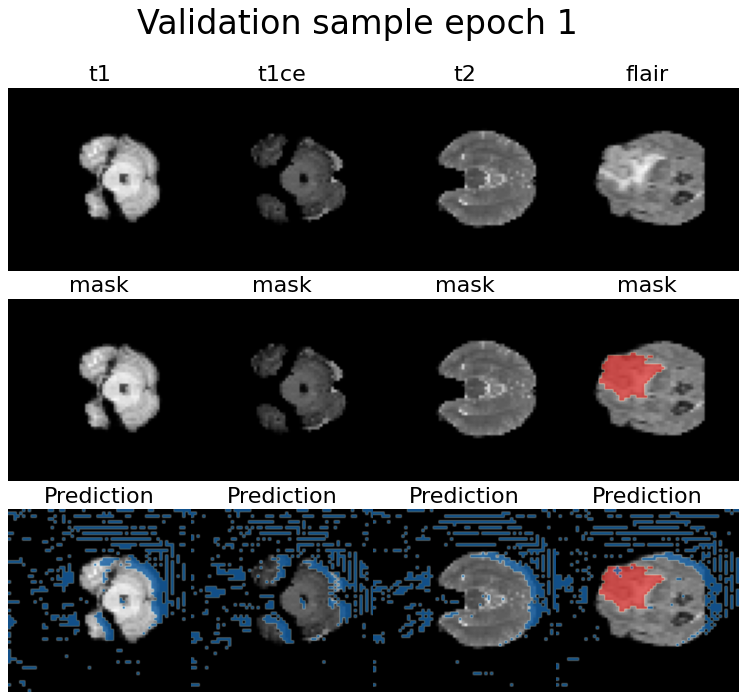

In [14]:
def prediction_threshold(y_pred:np.ndarray,threshold:float=0.5):
    y_pred = np.where(y_pred > threshold, 1, 0)
    return y_pred
def plot_sample(gen_data: DataGenerator,
                array_labels:List[str],
                model:Model=None,
                batch_idx:int=None,
                threshold:float=0.5,
                save:bool=False,
                save_path:str="./figures/",
                figure_name:str="sample.png",
                title:str="Samples",):
    # Get a batch of data.
    idx = batch_idx if batch_idx is not None else np.random.randint(0,len(gen_data))
    data = gen_data[idx]
    x, y = pre_prosses(data)
    # Preprocess the data.
    # Grid with one of each array_label.
    n_formats = len(array_labels)-1
    rows = 2 if not model else 3
    cols = n_formats
    preds = model.predict(x) if model else None
    if threshold:
        preds = prediction_threshold(preds,threshold) if model else None
    # Create a figure with the correct number of subplots.
    fig = plt.figure(figsize=(16, 10), dpi=80)
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(rows, cols), 
                    axes_pad=[0.0, 0.35],
                    )
    first_format = array_labels[0]
    for i, ax in enumerate(grid):
        # Get the row and column index.
        # Create masked images.
        row = i // cols
        col = i % cols
        alphas_label = np.ma.masked_array(y[col], mask=y[col]>=0)
        alphas_label = np.where(alphas_label, 0.7, 0).astype(np.float32).squeeze()
        # Plot the data.
        if row == 0:
            # ax.imshow(x[i+col*n_formats], cmap='gray')
            ax.imshow(x[col,...,col], cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"{array_labels[col]}", fontsize=20)
        elif row == 1:
            # Overlay the target on the input image.
            ax.imshow(x[col,...,col], cmap='gray', vmin=0, vmax=1)
            ax.imshow(alphas_label, cmap='Reds', vmin=0, vmax=1, alpha=alphas_label)
            ax.set_title(f"{array_labels[-1]}", fontsize=20)
        else:
            alphas = np.ma.masked_array(preds[col], mask=preds[col]>=0)
            # To binary mask
            alphas_pred = np.where(alphas, 0.8, 0).astype(np.float32).squeeze()
            ax.imshow(x[col,...,col], cmap='gray', vmin=0, vmax=1)
            ax.imshow(alphas_label, cmap='Reds', vmin=0, vmax=1, alpha=alphas_label)
            ax.imshow(alphas_pred, cmap='Blues', vmin=0, vmax=1, alpha=alphas_pred)
            ax.set_title(f"Prediction", fontsize=20)

        ax.axis('off')
    fig.suptitle(title, fontsize=30)
    # Tight 
    # plt.tight_layout()
    if save:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        fig.savefig(os.path.join(save_path,figure_name))
        plt.close(fig)
    else:
        plt.show()
plot_sample(gen_val, array_labels, batch_idx=2,model=generator, threshold=0.5, save=False, title=f"Validation sample epoch {1}")

/tmp/ipykernel_32375/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
/tmp/ipykernel_32375/3735593649.py:63: RuntimeWarning: invalid value encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


4/4 [==============================] - 0s 3ms/step


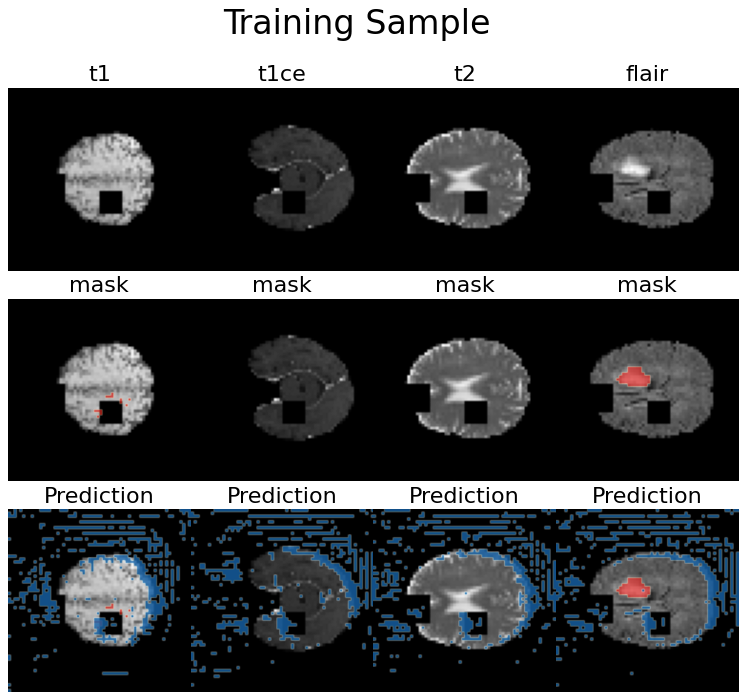

In [15]:
batch_size = 128
# Augmentator
augmentor = Augmentor(translate=0, # No translation. Due to lack of speed.
                      shear=0, # No shear. Due to lack of speed.
                      rotate=0, # No rotation. Due to lack of speed.
                      mask=0.8, # Probability of masking the image.
                      mask_size=0.2, # Maximum size of the mask as a fraction of the image size.
                      max_n_masks=6, # Maximum number of masks to apply.
                      noise=0.4, # Probability of adding Gaussian noise to the image.
                      noise_mean=0.05, # Mean of the noise.
                      noise_std=0.1, # Standard deviation of the noise.
                      ) # Augmentation of the data.
gen_train = DataGeneratorAugmented(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size,
                          augmentor=augmentor)
gen_val = DataGeneratorAugmented(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)
gen_test = DataGeneratorAugmented(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)
plot_sample(gen_train, array_labels,model=generator, batch_idx=2, save=False, title=f"Training Sample")

Epoch 20, Dice score: 0.7156. Diff: 0.0071
Epoch 20, validation uncertainty: 0.0026. Diff: 0.0001


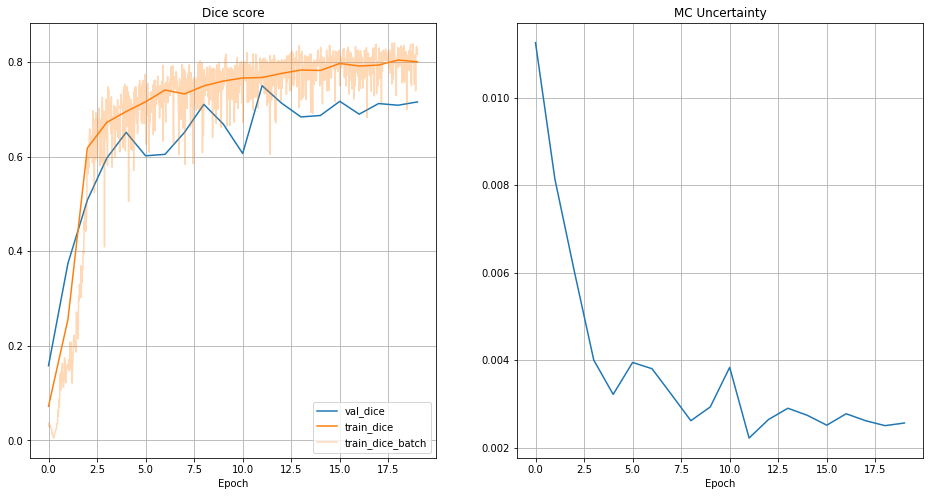

In [16]:
n_epochs = 20
prev_dice_score = 0
prev_unc = 0
plot_validating_dice = []
plot_training_dice = []
plot_validating_unc = []
best_dice_score = 0
batches_seen = 0
training_loss = []
n_batches = len(gen_train)
for epoch in range(n_epochs):
    validating_loss = []
    validating_unc = []
    plot_sample(gen_val, array_labels, model=generator, threshold=0.3, save=True, title=f"Validation sample epoch {epoch}", save_path=figure_path, figure_name=f"val_epoch_{epoch}.png")
    pbar = tqdm(total=len(gen_train), desc='Train Epoch %d/%d' % (epoch + 1, n_epochs))
    for idx, (inputs,mask) in enumerate(gen_train): # Add the additional inputs inside the brackets
        pbar.update(1)
        h = generator.train_on_batch(inputs, mask)
        training_loss.append(h[-1])
        batches_seen += 1
    pbar.close()
    plot_training_dice.append(np.mean(training_loss[n_batches*epoch:n_batches*(epoch+1)]))
    pbar = tqdm(total=len(gen_val), desc='Val Epoch %d/%d' % (epoch + 1, n_epochs))
    for idx, (inputs,mask) in enumerate(gen_val): # Add the additional inputs inside the brackets
        pbar.update(1)
        validating_loss.append(generator.test_on_batch(inputs, mask)[1])
        validating_unc.append(np.mean(generator_MCunc.predict(inputs).numpy()))
    pbar.close()
    plot_validating_dice.append(np.mean(validating_loss))
    plot_validating_unc.append(np.mean(validating_unc))
    
    val_dice = np.mean(validating_loss)
    val_unc = np.mean(validating_unc)
    diff_dice = val_dice - prev_dice_score
    diff_unc = val_unc - prev_unc
    prev_dice_score = val_dice
    prev_unc = val_unc
    if val_dice > best_dice_score:
        best_dice_score = val_dice
        path = os.path.join(checkpoint_path, f"best_dice_score")
        generator.save(path)
    if epoch % 5 == 0:
        path = os.path.join(checkpoint_path, f"epoch_{epoch}")
        generator.save(path)
    clear_output(wait=True)
    print(f"Epoch {epoch+1}, Dice score: {val_dice:.4f}. Diff: {diff_dice:.4f}")
    print(f"Epoch {epoch+1}, validation uncertainty: {val_unc:.4f}. Diff: {diff_unc:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_validating_dice, label="val_dice")
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_training_dice, label="train_dice",color='C1')
    axs[0].plot(np.linspace(0, epoch, batches_seen), training_loss, label="train_dice_batch", alpha=0.3, color='C1')
    axs[0].legend()
    axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_validating_unc, label="val_unc")
    axs[0].set_title("Dice score")
    axs[0].grid(True)
    axs[0].set_xlabel('Epoch')
    axs[1].set_title("MC Uncertainty")
    axs[1].grid(True)
    axs[1].set_xlabel('Epoch')
    # Second Row - Display some predictions
    plt.show()
    
    # if (np.mean(validating_loss) < 0.015):
    #     break

# NOTE: When should training stop? How long did it take to reach the required DICE score?
# NOTE: Describe what behavior you expect from the two plots?
# NOTE: Detail what outcomes you have faced when the training failed? Why do you think that happened? How did you try to fix it?

4/4 [==============================] - 0s 3ms/step


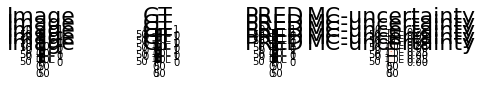

In [17]:
data = gen_val[np.random.randint(0, len(gen_val))] # Add the additional inputs
inputs, mask = pre_prosses(data)
prediction = generator.predict(inputs)
uncertainty = generator_MCunc.predict(inputs)
plt.figure(figsize=(8, 16))
for idx in range(5):
    plt.subplot(batch_size, 4, idx * 4 + 1)
    plt.imshow(inputs[idx,...,-2], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Image', fontsize=22)
    plt.subplot(batch_size, 4, idx * 4 + 2)
    plt.imshow(inputs[idx,...,-2], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('GT', fontsize=22)
    plt.subplot(batch_size, 4, idx * 4 + 3)
    plt.imshow(prediction[idx, :, :], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('PRED', fontsize=22)
    plt.subplot(batch_size, 4, idx * 4 + 4)
    plt.imshow(uncertainty[idx, :, :], cmap='Reds', vmin=0, vmax=np.max(uncertainty))
    plt.colorbar()
    plt.title('MC-uncertainty', fontsize=22)

# NOTE: How good do the images look like? What do you think is needed for better results?
# NOTE: Discuss the difference between false positives and false negatives in the segmentations.
# NOTE: Discuss the uncertainties. Where is it large, where is it small? Why? Is this what you would expect?

In [18]:
model:Model = keras.models.load_model(os.path.join(checkpoint_path, "best_dice_score"),custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss},compile=False)
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])
model.evaluate(gen_val)

7/7 [==============================] - 7s 977ms/step - loss: 0.2501 - dice_coef: 0.7499


[0.25005993247032166, 0.749940037727356]

In [19]:
model.evaluate(gen_test)

/tmp/ipykernel_32375/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


7/7 [==============================] - 7s 977ms/step - loss: 0.3016 - dice_coef: 0.6984


[0.3016141951084137, 0.6983857750892639]

4/4 [==============================] - 0s 3ms/step


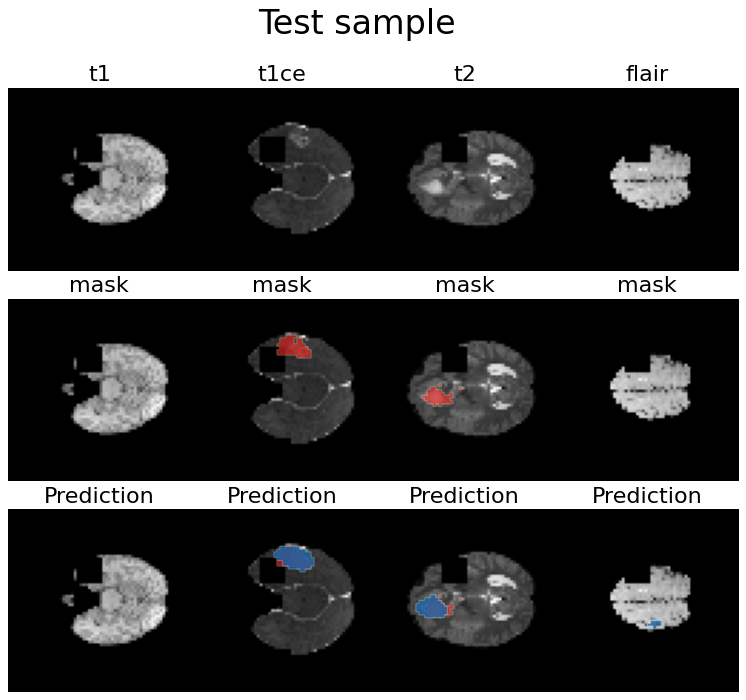

In [20]:
plot_sample(gen_train, array_labels, model=generator, threshold=0.5, save=False, title=f"Test sample")

(array([287.,  36.,  24.,  22.,  32., 111., 175., 146.,  52.,  11.]),
 array([0.00068415, 0.04634747, 0.0920108 , 0.13767412, 0.18333745,
        0.22900078, 0.2746641 , 0.32032743, 0.36599076, 0.41165408,
        0.45731741]),
 <BarContainer object of 10 artists>)

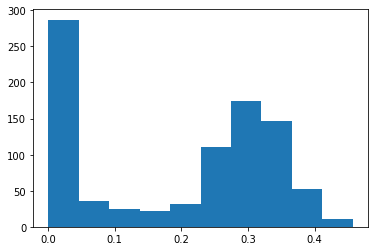

In [21]:
testing_loss = []
for idx, (data) in enumerate(gen_test): # Add the additional inputs inside the brackets
    inputs, mask = pre_prosses(data)
    mn = np.max(generator_MCunc.predict(inputs), axis=(1, 2, 3))
    testing_loss.extend(mn)
plt.hist(testing_loss)

# NOTE: Only evaluate the testing set, when you are not changing the code anymore.
# NOTE: How different is the performance on the validation and testing sets?
# NOTE: Do your results speak of overfitting? Underfitting?
# NOTE: This code evaluates the uncertainty maps. 
# NOTE: Explore the histogram, and investigate why some data samples might have larger uncertainties